# Implementation of Markov Partition Construction Algorithm in Chapter 4.2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

## Define System's Dynamics in Euclidean Plane and on Torus

In [2]:
A = np.array([[1,1], [1,0]])
A

array([[1, 1],
       [1, 0]])

In [3]:
def phi(x: np.array) -> np.array:
    x_new = np.dot(A, x) % 1
    return x_new

## Compute Eigendecomposition

In [4]:
# get eigenvalues and right eigenvectors, i.e. transposed eigenvectors
eig_vals, eig_vects = np.linalg.eig(A)
# retrieve eigenvectors from right eigenvectors
eig_vects = np.transpose(eig_vects)

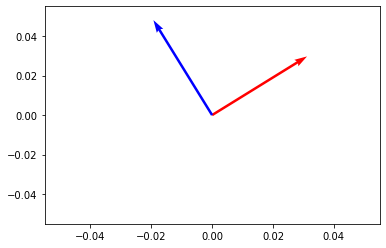

In [5]:
origin = [0], [0]
plt.quiver(*origin, eig_vects[:,0], eig_vects[:,1], color=['r','b'], scale=3)
plt.show()

In [6]:
print(f"Eigenvalues: {eig_vals}")

Eigenvalues: [ 1.61803399 -0.61803399]


In [7]:
print(f"Eigenvectors: {eig_vects}")

Eigenvectors: [[ 0.85065081  0.52573111]
 [-0.52573111  0.85065081]]


## Analysis of Hyperbolicity and Invertibility

In [8]:
def is_hyperbolic(eig_vals: np.array) -> bool:
    contr_seg = any(np.abs(eig_val) < 1 for eig_val in eig_vals)
    exp_seg = any(np.abs(eig_val) > 1 for eig_val in eig_vals)

    return contr_seg and exp_seg

In [9]:
system_hyperbolic = is_hyperbolic(eig_vals)
print(f"Dynamic system is hyperbolic: {system_hyperbolic}")

Dynamic system is hyperbolic: True


In [10]:
def is_invertible(A: np.array) -> bool:
    return np.abs(np.linalg.det(A)) == 1

In [11]:
system_invertible = is_invertible(A)
print(f"Dynamic system is invertble: {system_invertible}")

Dynamic system is invertble: True


## Computation of Bases for Contracting and Expanding Segments 

In [12]:
def expanding_segments(eig_vals: np.array, eig_vects: np.array) -> np.array:
    exp_eig_spaces_msk = np.abs(eig_vals) > 1
    print(exp_eig_spaces_msk)
    return eig_vects[exp_eig_spaces_msk]

In [13]:
def contracting_segments(eig_vals: np.array, eig_vects: np.array) -> np.array:
    contr_eig_spaces_msk = np.abs(eig_vals) < 1
    print(contr_eig_spaces_msk)
    return eig_vects[contr_eig_spaces_msk]

In [14]:
contr_segs = contracting_segments(eig_vals, eig_vects)
print(f"Contracting segments: {contr_segs}")

[False  True]
Contracting segments: [[-0.52573111  0.85065081]]


In [15]:
exp_segs = expanding_segments(eig_vals, eig_vects)
print(f"Expanding segments: {exp_segs}")

[ True False]
Expanding segments: [[0.85065081 0.52573111]]


## Translate between Euclidea Plane and Torus

In [16]:
def q(x: np.array) -> np.array:
    return x % 1

In [17]:
# sample point in R^2 between -10 and 10
x = np.random.uniform(low=-10, high=10, size=2)

In [18]:
# apply system's dynamics A in plane, then push down to torus by q
plane_dynamics_result = q(np.dot(A, x))
print(f"Next point on torus: {plane_dynamics_result}")

Next point on torus: [0.68740818 0.87544991]


In [19]:
# push down point to torus, then apply system's dynamics phi on torus
torus_dynamics_result = phi(q(x))
print(f"Next point on torus: {torus_dynamics_result}")

Next point on torus: [0.68740818 0.87544991]


In [20]:
if np.all(plane_dynamics_result == torus_dynamics_result):
    print(f"System dynamics in plane and on torus commute by q!")
else:
    print(f"System dynamics in plane and on torus do not commute by q!")

System dynamics in plane and on torus commute by q!


## Calculate Inetrsections between Lines

In [21]:
def perp(a) :
    b = np.empty_like(a)
    b[0] = -a[1]
    b[1] = a[0]
    return b

# line segment a given by endpoints a1, a2
# line segment b given by endpoints b1, b2
def seg_intersect(a, b) :
    a1, a2 = a
    b1, b2 = b

    da = a2 - a1
    db = b2 - b1
    dp = a1 - b1
    dap = perp(da)
    denom = np.dot(dap, db)
    num = np.dot(dap, dp)

    return (num / denom.astype(float))*db + b1

## Calculate Hyperbolic Fixed Point

In [22]:
# reformulate fixed point problem Ax = x as root finding problem Ax-x = 0
def objective_func(x: np.array) -> np.array:
    return np.dot(A, x) - x

In [23]:
# function that calculates jacobian of objective function, namely D(Ax-x) = A-I
def jac(x: np.array) -> np.array:
    return A - np.identity(n=2)

In [24]:
# find roots of objective function with Levenberg-Marquardt algorithm
root_sol = optimize.root(objective_func, np.array([1,2]), jac=jac, method="lm")
if not root_sol.success:
    print(f"Failed to find a fixed point. Error: {root_sol.message}")
else:
    fixed_point = root_sol.x
    print(f"Fixed point: {fixed_point}")

Fixed point: [0. 0.]


## Calculate Symmetric (un)stable Branches around Hyperbolic Fixed Point

In [25]:
r = 0.5

In [26]:
vs = eig_vects[np.abs(eig_vals) < 1][0]
vu = eig_vects[np.abs(eig_vals) > 1][0]
print(f"W^u: {vu}")
print(f"W^s: {vs}")

W^u: [0.85065081 0.52573111]
W^s: [-0.52573111  0.85065081]


In [27]:
x1 = q(fixed_point + r * vs)
x2 = q(fixed_point - r * vs)
print(f"x1: {x1}")
print(f"x2: {x2}")

x1: [0.73713444 0.4253254 ]
x2: [0.26286556 0.5746746 ]


In [28]:
y1 = q(fixed_point + r * vu)
y2 = q(fixed_point - r * vu)
print(f"y1: {y1}")
print(f"y2: {y2}")

y1: [0.4253254  0.26286556]
y2: [0.5746746  0.73713444]


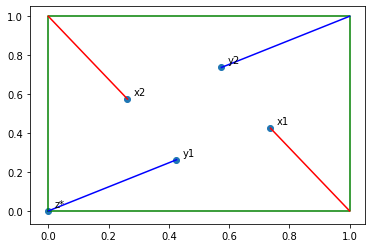

In [29]:
unit_square = np.array([[0,0], [0,1], [1,1], [1,0], [0,0]])
points = np.array([fixed_point, x1, x2, y1, y2])

w_x1 = np.array([[1,0],x1])
w_x2 = np.array([[0,1],x2])

w_y1 = np.array([[0,0],y1])
w_y2 = np.array([[1,1],y2])

fig, ax = plt.subplots()
ax.plot(unit_square[:, 0], unit_square[:, 1], "g")

ax.plot(w_x1[:,0], w_x1[:,1], "r")
ax.plot(w_x2[:,0], w_x2[:,1], "r")
ax.plot(w_y1[:,0], w_y1[:,1], "b")
ax.plot(w_y2[:,0], w_y2[:,1], "b")

ax.scatter(points[:, 0], points[:, 1])
labels = ["z*", "x1", "x2", "y1", "y2"]

for i, txt in enumerate(labels):
    ax.annotate(txt, (points[i, 0] + 0.02, points[i, 1] + 0.02))

## Trace Stable and Unstable Branches Analytically

In [30]:
def curve_intersections(z0: np.array, z1: np.array, v0: np.array, v1: np.array):
    """
    Compute the point in time of intersection between two linear parameterized curves.
    Args:
        z0 (np.array): origin of first curve
        z1 (np.array): origin of second curve
        v0 (np.array): direction vector of first curve
        v1 (np.array): direction vector of second curve

    Returns:
        t (float): time when first curve meets intersection point
        s (float): time when second curve meets intersection point
        p (np.array): intersection point
    """
    t = np.dot(v0, z1-z0)
    s = np.dot(v1, z0-z1)

    p = z0 + t * v0

    assert np.allclose(p, z1 + s * v1, atol=1e-08), "q(t) != r(s), something went wrong."

    return t, s, p

In [31]:
u1 = np.array([0,0])
u2 = np.array([0,1])
u3 = np.array([1,1])
u4 = np.array([1,0])

In [32]:
t1, s1, p1 = curve_intersections(u1, u2, vu, vs)

print(f"Time of intersection for W^u: {np.abs(t1)}")
print(f"Time of intersection for W^s: {np.abs(s1)}")

if np.abs(t1) > np.abs(s1):
    print("W^u ends onto W^s")
else:
    print("W^s ends onto W^u")

print(f"Parametrically calculated point of intersection: {p1}")

Time of intersection for W^u: 0.5257311121191335
Time of intersection for W^s: 0.8506508083520399
W^s ends onto W^u
Parametrically calculated point of intersection: [0.4472136 0.2763932]


In [33]:
t2, s2, p2 = curve_intersections(u1, u4, vu, vs)

print(f"Time of intersection for W^u: {np.abs(t2)}")
print(f"Time of intersection for W^s: {np.abs(s2)}")

if np.abs(t2) > np.abs(s2):
    print("W^u ends onto W^s")
else:
    print("W^s ends onto W^u")

print(f"Parametrically calculated point of intersection: {p2}")

Time of intersection for W^u: 0.8506508083520399
Time of intersection for W^s: 0.5257311121191335
W^u ends onto W^s
Parametrically calculated point of intersection: [0.7236068 0.4472136]


In [34]:
t3, s3, p3 = curve_intersections(u3, u4, vu, vs)

print(f"Time of intersection for W^u: {np.abs(t3)}")
print(f"Time of intersection for W^s: {np.abs(s3)}")

if np.abs(t3) > np.abs(s3):
    print("W^u ends onto W^s")
else:
    print("W^s ends onto W^u")

print(f"Parametrically calculated point of intersection: {p3}")

Time of intersection for W^u: 0.5257311121191335
Time of intersection for W^s: 0.8506508083520399
W^s ends onto W^u
Parametrically calculated point of intersection: [0.5527864 0.7236068]


In [35]:
t4, s4, p4 = curve_intersections(u3, u2, vu, vs)

print(f"Time of intersection for W^u: {np.abs(t4)}")
print(f"Time of intersection for W^s: {np.abs(s4)}")

if np.abs(t4) > np.abs(s4):
    print("W^u ends onto W^s")
else:
    print("W^s ends onto W^u")

print(f"Parametrically calculated point of intersection: {p4}")

Time of intersection for W^u: 0.8506508083520399
Time of intersection for W^s: 0.5257311121191335
W^u ends onto W^s
Parametrically calculated point of intersection: [0.2763932 0.5527864]


In [36]:
print(f"First eigenvector: ({eig_vects[0,0]}, {eig_vects[0,1]})")

First eigenvector: (0.8506508083520399, 0.5257311121191335)


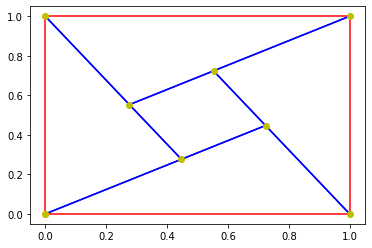

In [37]:
u = np.array([u1, u2, u3, u4, u1])
p = np.array([p1, p2, p3, p4])

P1 = np.array([p1, p2, p3, p4, p1])

P2a = np.array([u1, p2, u4])
P2b = np.array([u2, p4, u3])

P3a = np.array([u1, p1, u2])
P3b = np.array([u3, p3, u4])

#draw unit square
plt.plot(u[:, 0], u[:, 1], "r")

# draw rectangle P1
plt.plot(P1[:, 0], P1[:, 1], "b-")

# draw rectangle P2
plt.plot(P2a[:, 0], P2a[:, 1], "b-")
plt.plot(P2b[:, 0], P2b[:, 1], "b-")

# draw rectangle P3
plt.plot(P3a[:, 0], P3a[:, 1], "b-")
plt.plot(P3b[:, 0], P3b[:, 1], "b-")

# draw rectangle vertices
plt.plot(p[:, 0], p[:, 1], "yo")
plt.plot(u[:, 0], u[:, 1], "yo")

plt.show()

In [38]:
P1_phi = np.array([phi(p1), phi(p2), phi(p3), phi(p4)])

phi_p1_a = seg_intersect(np.array([u3,u4]), np.array([phi(p1), phi(p1)+vu]))
phi_p2_a = seg_intersect(np.array([u1,u2]), np.array([phi(p2), phi(p2)-vu]))
phi_p3_a = seg_intersect(np.array([u1,u2]), np.array([phi(p3), phi(p3)-vu]))
phi_p4_a = seg_intersect(np.array([u3,u4]), np.array([phi(p4), phi(p4)+vu]))

P1_phi_boundaries_a = np.array([phi(p1), phi_p1_a, phi_p4_a, phi(p4)])
P1_phi_boundaries_b = np.array([phi_p3_a, phi_p2_a, phi(p2), phi(p3)])

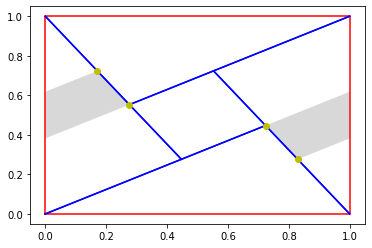

In [39]:
u = np.array([u1, u2, u3, u4, u1])
p = np.array([p1, p2, p3, p4])

P1 = np.array([p1, p2, p3, p4, p1])

P2a = np.array([u1, p2, u4])
P2b = np.array([u2, p4, u3])

P3a = np.array([u1, p1, u2])
P3b = np.array([u3, p3, u4])

#draw unit square
plt.plot(u[:, 0], u[:, 1], "r")

# draw rectangle P1
plt.plot(P1[:, 0], P1[:, 1], "b-")

# draw rectangle P2
plt.plot(P2a[:, 0], P2a[:, 1], "b-")
plt.plot(P2b[:, 0], P2b[:, 1], "b-")

# draw rectangle P3
plt.plot(P3a[:, 0], P3a[:, 1], "b-")
plt.plot(P3b[:, 0], P3b[:, 1], "b-")

# draw P1-phi rectangle vertices
plt.plot(P1_phi[:, 0], P1_phi[:, 1], "yo")

# draw P1-phi rectangle area
plt.fill(P1_phi_boundaries_a[:, 0], P1_phi_boundaries_a[:, 1], "gray", alpha=0.3)
plt.fill(P1_phi_boundaries_b[:, 0], P1_phi_boundaries_b[:, 1], "gray", alpha=0.3)

plt.show()

In [40]:
P2_phi = np.array([phi(u1)+np.array([1,0]), phi(p2), phi(u4)+np.array([0,1]), phi(p4)])

phi_p1_a = seg_intersect(np.array([u3,u4]), np.array([phi(p1), phi(p1)+vu]))
phi_p2_a = seg_intersect(np.array([u1,u2]), np.array([phi(p2), phi(p2)-vu]))
phi_p3_a = seg_intersect(np.array([u1,u2]), np.array([phi(p3), phi(p3)-vu]))
phi_p4_a = seg_intersect(np.array([u3,u4]), np.array([phi(p4), phi(p4)+vu]))

P2_phi_boundaries_a = np.array([u2, phi(p2), phi_p2_a])
P2_phi_boundaries_b = np.array([u4, phi(p4), phi_p4_a])
P2_phi_boundaries_c = np.array([u3, phi_p3_a, u1, phi_p1_a])

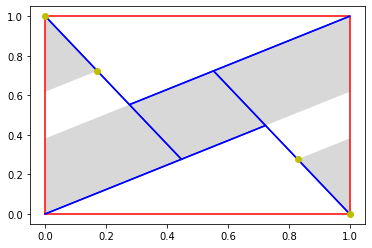

In [41]:
u = np.array([u1, u2, u3, u4, u1])
p = np.array([p1, p2, p3, p4])

P1 = np.array([p1, p2, p3, p4, p1])

P2a = np.array([u1, p2, u4])
P2b = np.array([u2, p4, u3])

P3a = np.array([u1, p1, u2])
P3b = np.array([u3, p3, u4])

#draw unit square
plt.plot(u[:, 0], u[:, 1], "r")

# draw rectangle P1
plt.plot(P1[:, 0], P1[:, 1], "b-")

# draw rectangle P2
plt.plot(P2a[:, 0], P2a[:, 1], "b-")
plt.plot(P2b[:, 0], P2b[:, 1], "b-")

# draw rectangle P3
plt.plot(P3a[:, 0], P3a[:, 1], "b-")
plt.plot(P3b[:, 0], P3b[:, 1], "b-")

# draw P2-phi rectangle vertices
plt.plot(P2_phi[:, 0], P2_phi[:, 1], "yo")

# draw P2-phi rectangle area
plt.fill(P2_phi_boundaries_a[:, 0], P2_phi_boundaries_a[:, 1], "gray", alpha=0.3)
plt.fill(P2_phi_boundaries_b[:, 0], P2_phi_boundaries_b[:, 1], "gray", alpha=0.3)
plt.fill(P2_phi_boundaries_c[:, 0], P2_phi_boundaries_c[:, 1], "gray", alpha=0.3)

plt.show()

In [42]:
P3_phi = np.array([phi(u1), phi(p1), phi(u2)+np.array([1,0]), phi(p3)])

P3_phi_boundaries_a = np.array([u1, phi(p1), u4])
P3_phi_boundaries_b = np.array([u2, phi(p3), u3])

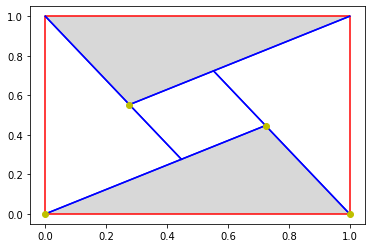

In [43]:
u = np.array([u1, u2, u3, u4, u1])
p = np.array([p1, p2, p3, p4])

P1 = np.array([p1, p2, p3, p4, p1])

P2a = np.array([u1, p2, u4])
P2b = np.array([u2, p4, u3])

P3a = np.array([u1, p1, u2])
P3b = np.array([u3, p3, u4])

#draw unit square
plt.plot(u[:, 0], u[:, 1], "r")

# draw rectangle P1
plt.plot(P1[:, 0], P1[:, 1], "b-")

# draw rectangle P2
plt.plot(P2a[:, 0], P2a[:, 1], "b-")
plt.plot(P2b[:, 0], P2b[:, 1], "b-")

# draw rectangle P3
plt.plot(P3a[:, 0], P3a[:, 1], "b-")
plt.plot(P3b[:, 0], P3b[:, 1], "b-")

# draw P3-phi rectangle vertices
plt.plot(P3_phi[:, 0], P3_phi[:, 1], "yo")

# draw P3-phi rectangle area
plt.fill(P3_phi_boundaries_a[:, 0], P3_phi_boundaries_a[:, 1], "gray", alpha=0.3)
plt.fill(P3_phi_boundaries_b[:, 0], P3_phi_boundaries_b[:, 1], "gray", alpha=0.3)

plt.show()